In [45]:
import calendar

import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import cmocean
import numpy as np

In [2]:
ds = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/tas/gr/v20180803/tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc')

In [3]:
ds

<xarray.Dataset> Size: 163MB
Dimensions:      (lat: 143, lon: 144, time: 1980, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 572B -90.0 -88.73 -87.46 ... 87.46 88.73 90.0
  * lon          (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
    height       float64 8B ...
  * time         (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-1...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] 32kB ...
    tas          (time, lat, lon) float32 163MB ...
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-11T07:36:34Z
    tracking_id:            hdl:21.14100/285a3a27-0287-4e3b-8232-69ddc89cebef
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    ...                     ...
    name:                   /ccc/work/cont003/gencmip6/p86caub/IGCM_OUT/IPSLC...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    variant_label:          r1i1p1f1
    realization_index:      1
    history:                Sat Dec  1 12:16:58 2018: ncatted -O -a realizati...
    NCO:                    "4.6.0"

In [4]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')

In [5]:
states_gp['abbrev'] = ['NSW', 'VIC', 'QLD', 'SA', 'WA', 'TAS', 'NT', 'ACT', 'OT']

In [6]:
states_gp

,STE_NAME21,AREASQKM21,LOCI_URI21,geometry,abbrev
0,New South Wales,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218...",NSW
1,Victoria,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341...",VIC
2,Queensland,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072...",QLD
3,South Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006...",SA
4,Western Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961...",WA
5,Tasmania,6.801754e+04,http://linked.data.gov.au/dataset/asgsed3/STE/6,"MULTIPOLYGON (((144.60439 -41.01001, 144.60443...",TAS
6,Northern Territory,1.348134e+06,http://linked.data.gov.au/dataset/asgsed3/STE/7,"MULTIPOLYGON (((133.02818 -10.90839, 133.02982...",NT
7,Australian Capital Territory,2.358133e+03,http://linked.data.gov.au/dataset/asgsed3/STE/8,"POLYGON ((149.06239 -35.15910, 149.09134 -35.1...",ACT
8,Other Territories,2.557420e+02,http://linked.data.gov.au/dataset/asgsed3/STE/9,"MULTIPOLYGON (((167.94747 -29.12757, 167.94748...",OT


In [7]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="abbrev",
    name="states"
)

In [8]:
states_regions

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW              New South Wales
1 VIC                     Victoria
2 QLD                   Queensland
3  SA              South Australia
4  WA            Western Australia
5 TAS                     Tasmania
6  NT           Northern Territory
7 ACT Australian Capital Territory
8  OT            Other Territories

[9 regions]

## Simple 2D masks

regionmask requires that the spatial coords are called lat and lon

In [9]:
#mask2d = regionmask.mask_geopandas(states_gp, lons, lats)
mask2d = states_regions.mask(ds)

In [10]:
mask2d

<xarray.DataArray 'mask' (lat: 143, lon: 144)> Size: 165kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 572B -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
    height   float64 8B 2.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:  region
    flag_values:    [0 1 2 3 4 5 6]
    flag_meanings:  NSW VIC QLD SA WA TAS NT

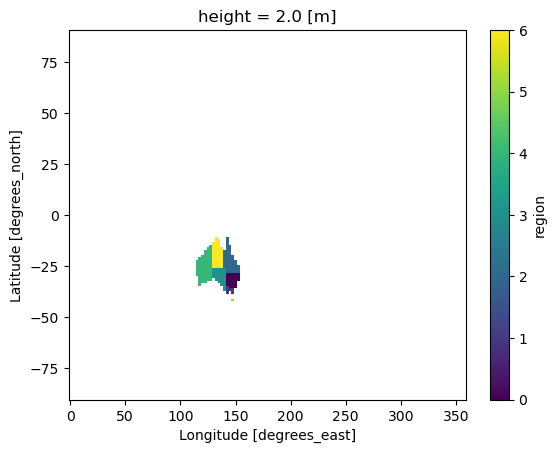

In [11]:
mask2d.plot()

In [12]:
mask2d.cf

Flag Variable:
       Flag Meanings:   NSW:     0 
                        VIC:     1 
                        QLD:     2 
                         SA:     3 
                         WA:     4 
                        TAS:     5 
                         NT:     6 

Coordinates:
             CF Axes: * X: ['lon']
                      * Y: ['lat']
                        Z: ['height']
                        T: n/a

      CF Coordinates: * longitude: ['lon']
                      * latitude: ['lat']
                        vertical: ['height']
                        time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   height: ['height']
                      * latitude: ['lat']
                      * longitude: ['lon']

              Bounds:   n/a

       Grid Mappings:   n/a

In [13]:
#mask_QLD = mask2d.cf == "QLD"

### Select a region

In [14]:
ds_qld = ds.where(mask2d.cf == 'QLD')

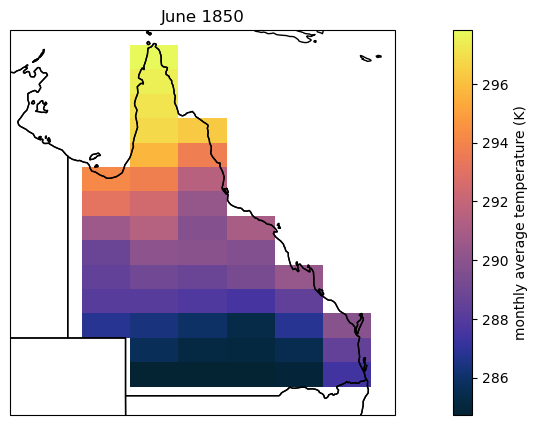

In [53]:
fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_qld['tas'].isel(time=5).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal,
#    levels=np.arange(5, 35, 2.5),
    cbar_kwargs={'label': f'monthly average temperature (K)'},
)
ax.set_extent([135, 155, -10, -30], crs=ccrs.PlateCarree())
ax.set_title('June 1850')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
plt.show()

### Calculate weighted regional average

In [25]:
weights = np.cos(np.deg2rad(ds['lat']))
tas_qld = ds_qld['tas'].weighted(weights).mean(dim=("lat", "lon"))

In [26]:
tas_qld

<xarray.DataArray 'tas' (time: 1980)> Size: 8kB
array([297.66464, 297.74213, 296.5999 , ..., 297.6581 , 298.1495 ,
       298.26285], dtype=float32)
Coordinates:
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...

In [27]:
tas_qld_clim = tas_qld.groupby('time.month').mean()

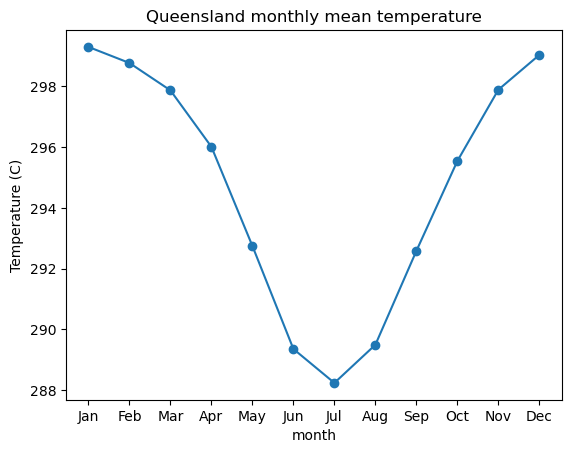

In [30]:
months = np.arange(1, 13)
plt.plot(months, tas_qld_clim.values, marker='o')
plt.ylabel("Temperature (C)")
plt.xlabel("month")
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.title('Queensland monthly mean temperature')
plt.show()

### 3D masks

In [31]:
#mask3d = regionmask.mask_3D_geopandas(shapes, lons, lats)
mask3d = states_regions.mask_3D(ds)

In [32]:
mask3d

<xarray.DataArray 'mask' (region: 7, lat: 143, lon: 144)> Size: 144kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float32 572B -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
    height   float64 8B 2.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * region   (region) int64 56B 0 1 2 3 4 5 6
    abbrevs  (region) <U3 84B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'NT'
    names    (region) <U18 504B 'New South Wales' ... 'Northern Territory'
Attributes:
    standard_name:  region

Per default this creates a mask containing one layer (slice) for each region containing (at least) one gridpoint, so OT has been left out.

/jobfs/117303037.gadi-pbs/ipykernel_3709847/2303516815.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flatten():


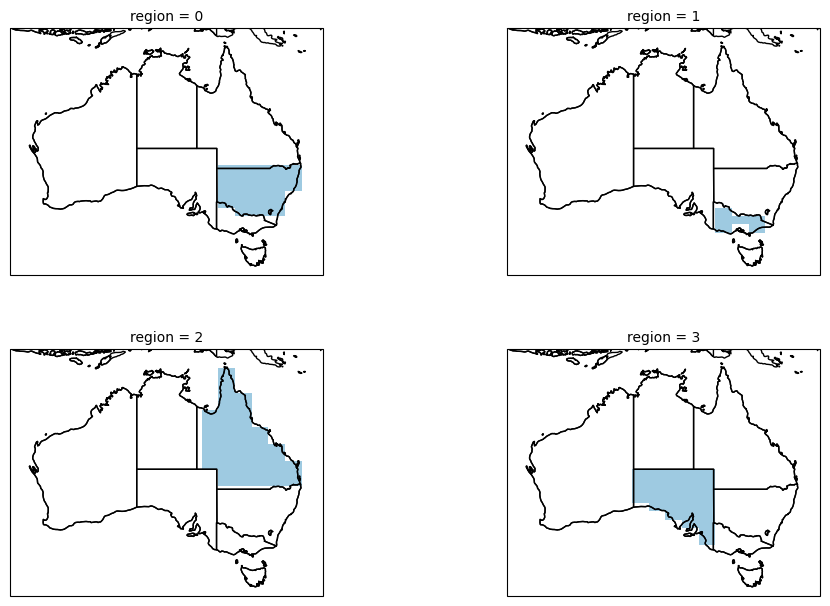

In [46]:
fg = mask3d.isel(region=slice(4)).plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=2,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    aspect=1.5,
    cmap=mplc.ListedColormap(["none", "#9ecae1"]),
)

for ax in fg.axes.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)

fg.fig.subplots_adjust(hspace=0.3, wspace=0.05)

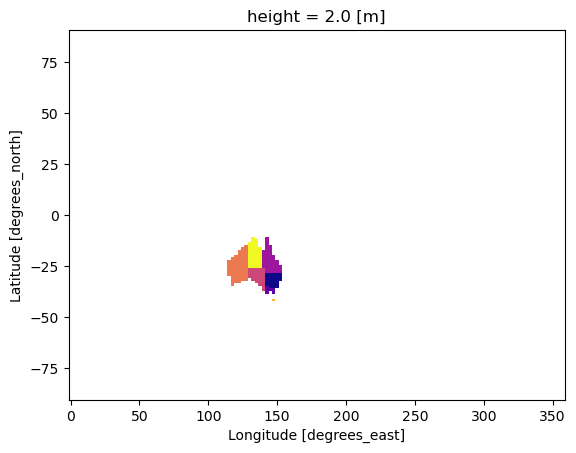

In [47]:
regionmask.plot_3D_mask(mask3d, add_colorbar=False, cmap="plasma")

In [48]:
#vic_mask = mask3d.sel(region=1)
#vic_mask = mask3d.isel(region=(mask3d.abbrevs == "VIC"))
vic_mask = mask3d.isel(region=(mask3d.names == "Victoria"))

In [49]:
vic_mask

<xarray.DataArray 'mask' (region: 1, lat: 143, lon: 144)> Size: 21kB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float32 572B -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
    height   float64 8B 2.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * region   (region) int64 8B 1
    abbrevs  (region) <U3 12B 'VIC'
    names    (region) <U18 72B 'Victoria'
Attributes:
    standard_name:  region

In [50]:
ds_vic = ds.where(vic_mask)

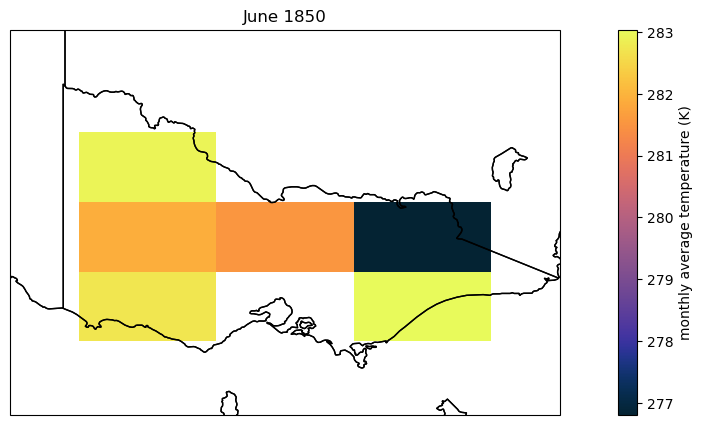

In [56]:
fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds_vic['tas'].isel(time=5).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.thermal,
#    levels=np.arange(5, 35, 2.5),
    cbar_kwargs={'label': f'monthly average temperature (K)'},
)
ax.set_extent([140, 150, -33, -40], crs=ccrs.PlateCarree())
ax.set_title('June 1850')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
plt.show()

In [57]:
weights = np.cos(np.deg2rad(ds['lat']))
tas_regional = ds['tas'].weighted(mask3d * weights).mean(dim=("lat", "lon"))

In [58]:
tas_regional

<xarray.DataArray 'tas' (time: 1980, region: 7)> Size: 55kB
array([[293.55856, 288.31818, 297.66467, ..., 297.96677, 284.47784,
        298.90723],
       [296.35965, 294.43408, 297.74213, ..., 299.02292, 288.45483,
        298.6851 ],
       [292.82797, 290.37735, 296.59988, ..., 299.64227, 286.90762,
        298.29904],
       ...,
       [291.33862, 285.2653 , 297.6581 , ..., 295.4634 , 281.62595,
        299.1008 ],
       [292.6657 , 288.46533, 298.1495 , ..., 297.7715 , 283.49435,
        299.39465],
       [295.66556, 291.37506, 298.26282, ..., 300.88556, 285.92313,
        299.85086]], dtype=float32)
Coordinates:
    height   float64 8B 2.0
  * time     (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T12...
  * region   (region) int64 56B 0 1 2 3 4 5 6
    abbrevs  (region) <U3 84B 'NSW' 'VIC' 'QLD' 'SA' 'WA' 'TAS' 'NT'
    names    (region) <U18 504B 'New South Wales' ... 'Northern Territory'

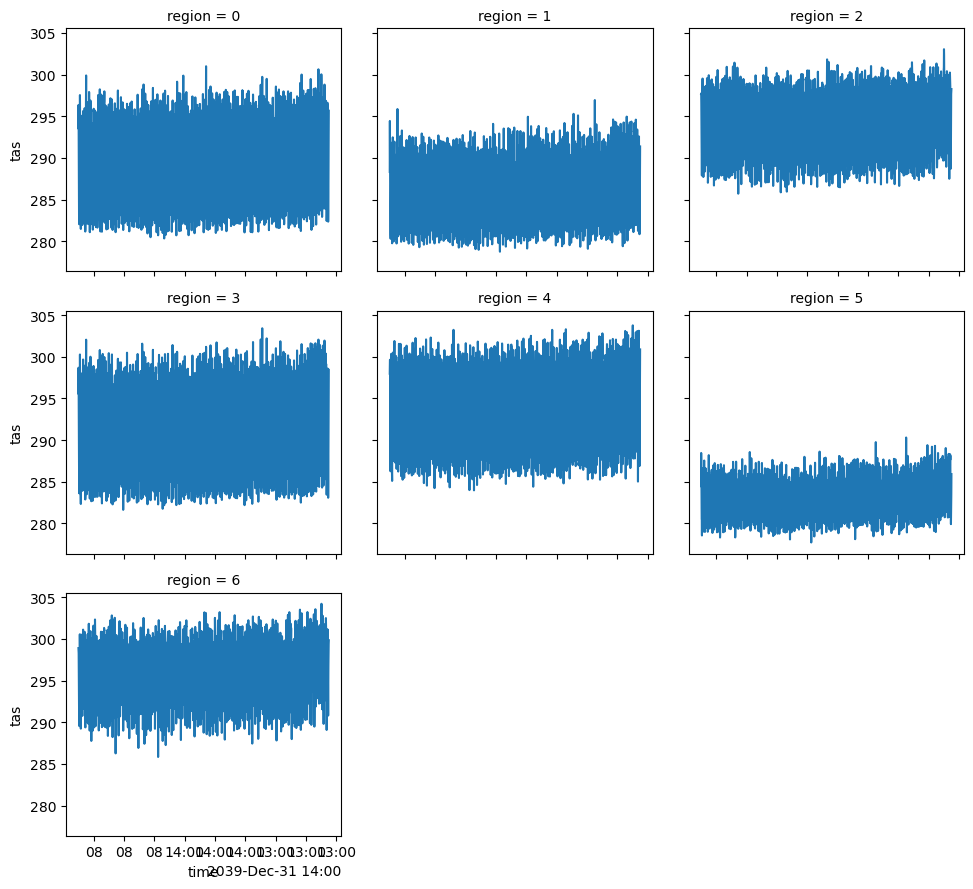

In [60]:
tas_regional.plot(col="region", col_wrap=3)

In [61]:
tas_regional_clim = tas_regional.groupby('time.month').mean()

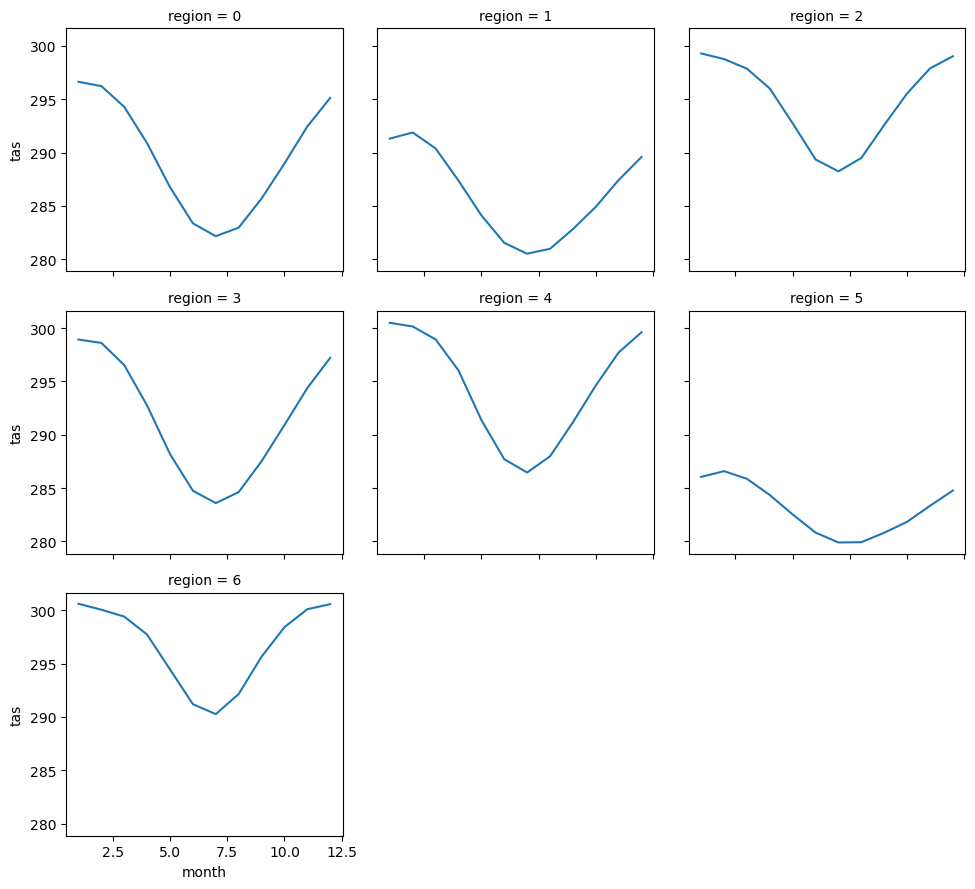

In [62]:
tas_regional_clim.plot(col="region", col_wrap=3)